# Modeling the Driving Factors of Urban Heat Disparities 

## CODE Modified by AJF

1/20/2025

We can use our models to understand the driving factors of urban heat and then leverage interpretability techniques to compare the enviromental factors of urban heat to demographic information. Here, we use an XGBoost model and then take advantage of the SHAP values to derive insights from our data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import shap
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Processing

In [2]:
features = ['Black', 'Hispanic', 'White', 'Below Poverty', 
            'Population Density', 'BSA', 
            'NDBI', 'NDVI', 'Spatial Lag']
label = 'UHI'

In [3]:
data = pd.read_csv('data/data.csv', usecols=features+[label])

Let's look at the missing data.

In [4]:
pd.DataFrame({'Total Missing': data.isna().sum(), 
              'Percent Missing': (data.isna().sum() / len(data)) * 100 })

Total Missing  Percent Missing
BSA                             0         0.000000
NDBI                            0         0.000000
NDVI                            0         0.000000
UHI                             0         0.000000
Black                         280         0.394917
Hispanic                      280         0.394917
White                         256         0.361067
Below Poverty                 428         0.603659
Spatial Lag                     0         0.000000
Population Density              0         0.000000

In [5]:
# We can drop the missing values or interpolate
data = data.interpolate(method='nearest')

In [6]:
# Separate the features and target
X, y = data[features], data[['UHI']]

# Split the data into training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Model Development
Here, we train the model. Here, we use the scikit-learn API. If you have a more advanced appreciation for XGBoost and wish to use the default API, then feel free to do so. 

Note on hyperparameter tuning: For this specific dataset, I did not see a difference in the performance between tuning my parameters and the default parameters. There is debate on the research side of the merits of parameter tuning in academic studies. For XGBoost, there is no standard method for parameter tuning, but random search cross validation, hyperopt, and optuna are available options. As the XGBoost documentation puts it, "Parameter tuning is a dark art in machine learning, the optimal parameters of a model can depend on many scenarios". 

Now, let's train the model.
1. Update the number of estimators parameter *n_estimators*. Feel free to play arond with other hyperparameters too.
2. Use the *fit* method with the training data.

In [7]:
# Train a model using the scikit-learn API
model = XGBRegressor(n_estimators=100, objective='reg:squarederror', tree_method='hist', enable_categorical=True)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

*Congratulations!* You just trained a machine learning model! Now let's see how well it performs.

## Modelling Notes

**XGBoost Links**
* https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
* https://colab.research.google.com/github/jofaval/xgboost-cheatsheet/blob/master/notebook.ipynb#scrollTo=maysizPak6FI
* https://colab.research.google.com/github/ocademy-ai/machine-learning/blob/release/open-machine-learning-jupyter-book/ml-advanced/gradient-boosting/xgboost.ipynb#scrollTo=5fedf9e7
* https://github.com/ocademy-ai/machine-learning

**XGBoost Notes**
* Image of the cycle: https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/ml-advanced/xgboost/Gradient_boosted_decision_trees.png
* leading model for working with standard tabular data
* minimizes a regularized (L1 and L2) objective function that combines a convex loss function (based on the difference between the predicted and target outputs) and a penalty term for model complexity (in other words, the regression tree functions).As per specified at: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-HowItWorks.html
* Do **not** use for: NLP, more features than samples, timeseries
* Parameters: "n_estimators" specifies how many times to go through the modeling cycle; Too low an n_estimator value causes underfitting and too high causes overfitting; Typical values range from 100-1000, though this depends a lot on the "learning rate"; Setting and "early_stopping_rounds" tries to automatically find ideal values by stopping when validation score stops improving.
* In general, a small learning rate (and large number of estimators) will yield more accurate XGBoost models

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27 --
The SHAP values we use here result from a unification of several individualized model interpretation methods connected to Shapley values.Since SHAP values have guaranteed consistency we don’t need to worry about the kinds of contradictions we found before using the gain, or split count methods.es

## Understanding the Model

In [9]:
# This is a continuos model (not discrete classifier)
booster = model.get_booster()
tree_df = booster.trees_to_dataframe()
tree_df.columns

Index(['Tree', 'Node', 'ID', 'Feature', 'Split', 'Yes', 'No', 'Missing',
       'Gain', 'Cover', 'Category'],
      dtype='object')

#### Two ways to plot model-specific feature importance

                    Importance    percent
Spatial Lag             1217.0  20.697279
BSA                      849.0  14.438776
NDBI                     672.0  11.428571
NDVI                     661.0  11.241497
Population Density       650.0  11.054422
Black                    537.0   9.132653
Hispanic                 511.0   8.690476
White                    429.0   7.295918
Below Poverty            354.0   6.020408


[Text(0.5, 1.0, 'Percent Importance of Feature')]

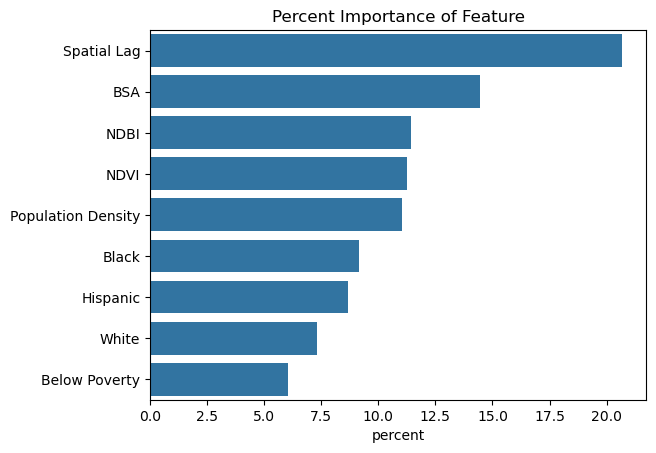

In [10]:
# Method1 - booster.get_fscore -- convert to %
df_importance = pd.Series(booster.get_fscore(),name='Importance').sort_values(ascending=False).to_frame() # get feature importance and plot -defualt is weight
df_importance['percent'] = df_importance / df_importance.sum() *100
print(df_importance)
sns.barplot(data=df_importance['percent'], orient='h').set(title='Percent Importance of Feature')

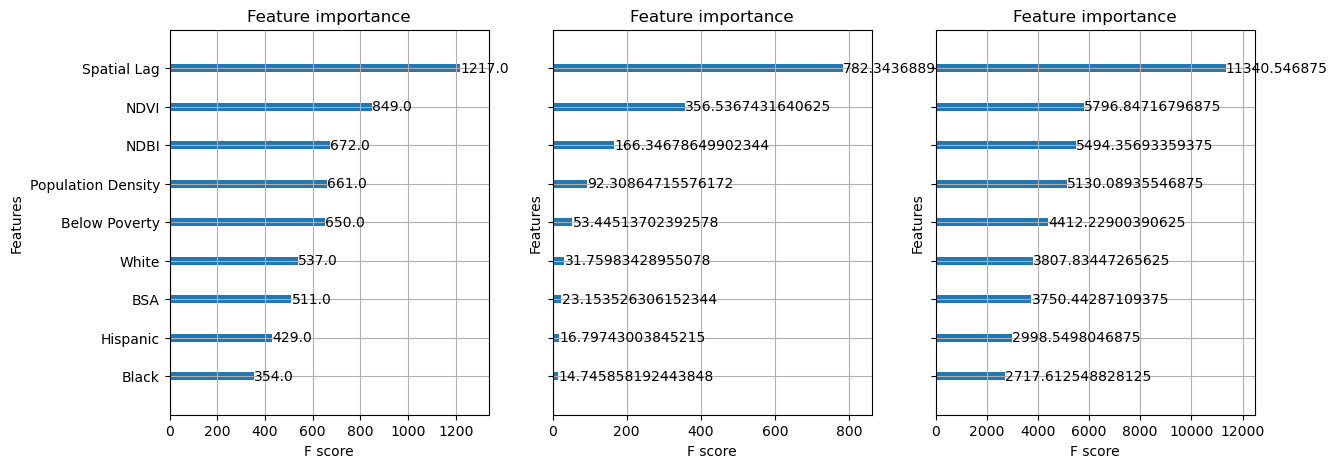

In [11]:
# Method 2: from xgboost import plot_importance
from xgboost import plot_importance
# Plot feature importance

type=['weight','gain','cover']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=True)
for i in range(3):
    plot_importance(model, importance_type=type[i], ax=axes[i])

# Weight - default, The number of times a feature is used to split the data across all trees.
# Cover - number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
# Gain - difference in error before and after splitting the data on a particular feature value. A higher gain score means the split leads to a more significant improvement in predicting the target variable.

    
#plt.figure(figsize=(10,5))
#plot_importance(model)
#plt.show()

The plots visually represent how features contribute to the final output, allowing for a deeper insight into the model's decision-making process.
Feature importance in XGBoost is typically assessed using Shapley values, which provide a measure of the contribution of each feature to the model's predictions. The mean absolute Shapley values indicate the average impact of each feature:

#### Understanding the Trees

In [12]:
tree_df.head(2)

Tree  Node   ID      Feature     Split  Yes   No Missing         Gain  \
0     0     0  0-0  Spatial Lag  3.097721  0-1  0-2     0-2  327569.1880   
1     0     1  0-1  Spatial Lag -0.588950  0-3  0-4     0-4   81938.2969   

     Cover  Category  
0  56720.0       NaN  
1  27683.0       NaN

<Axes: >

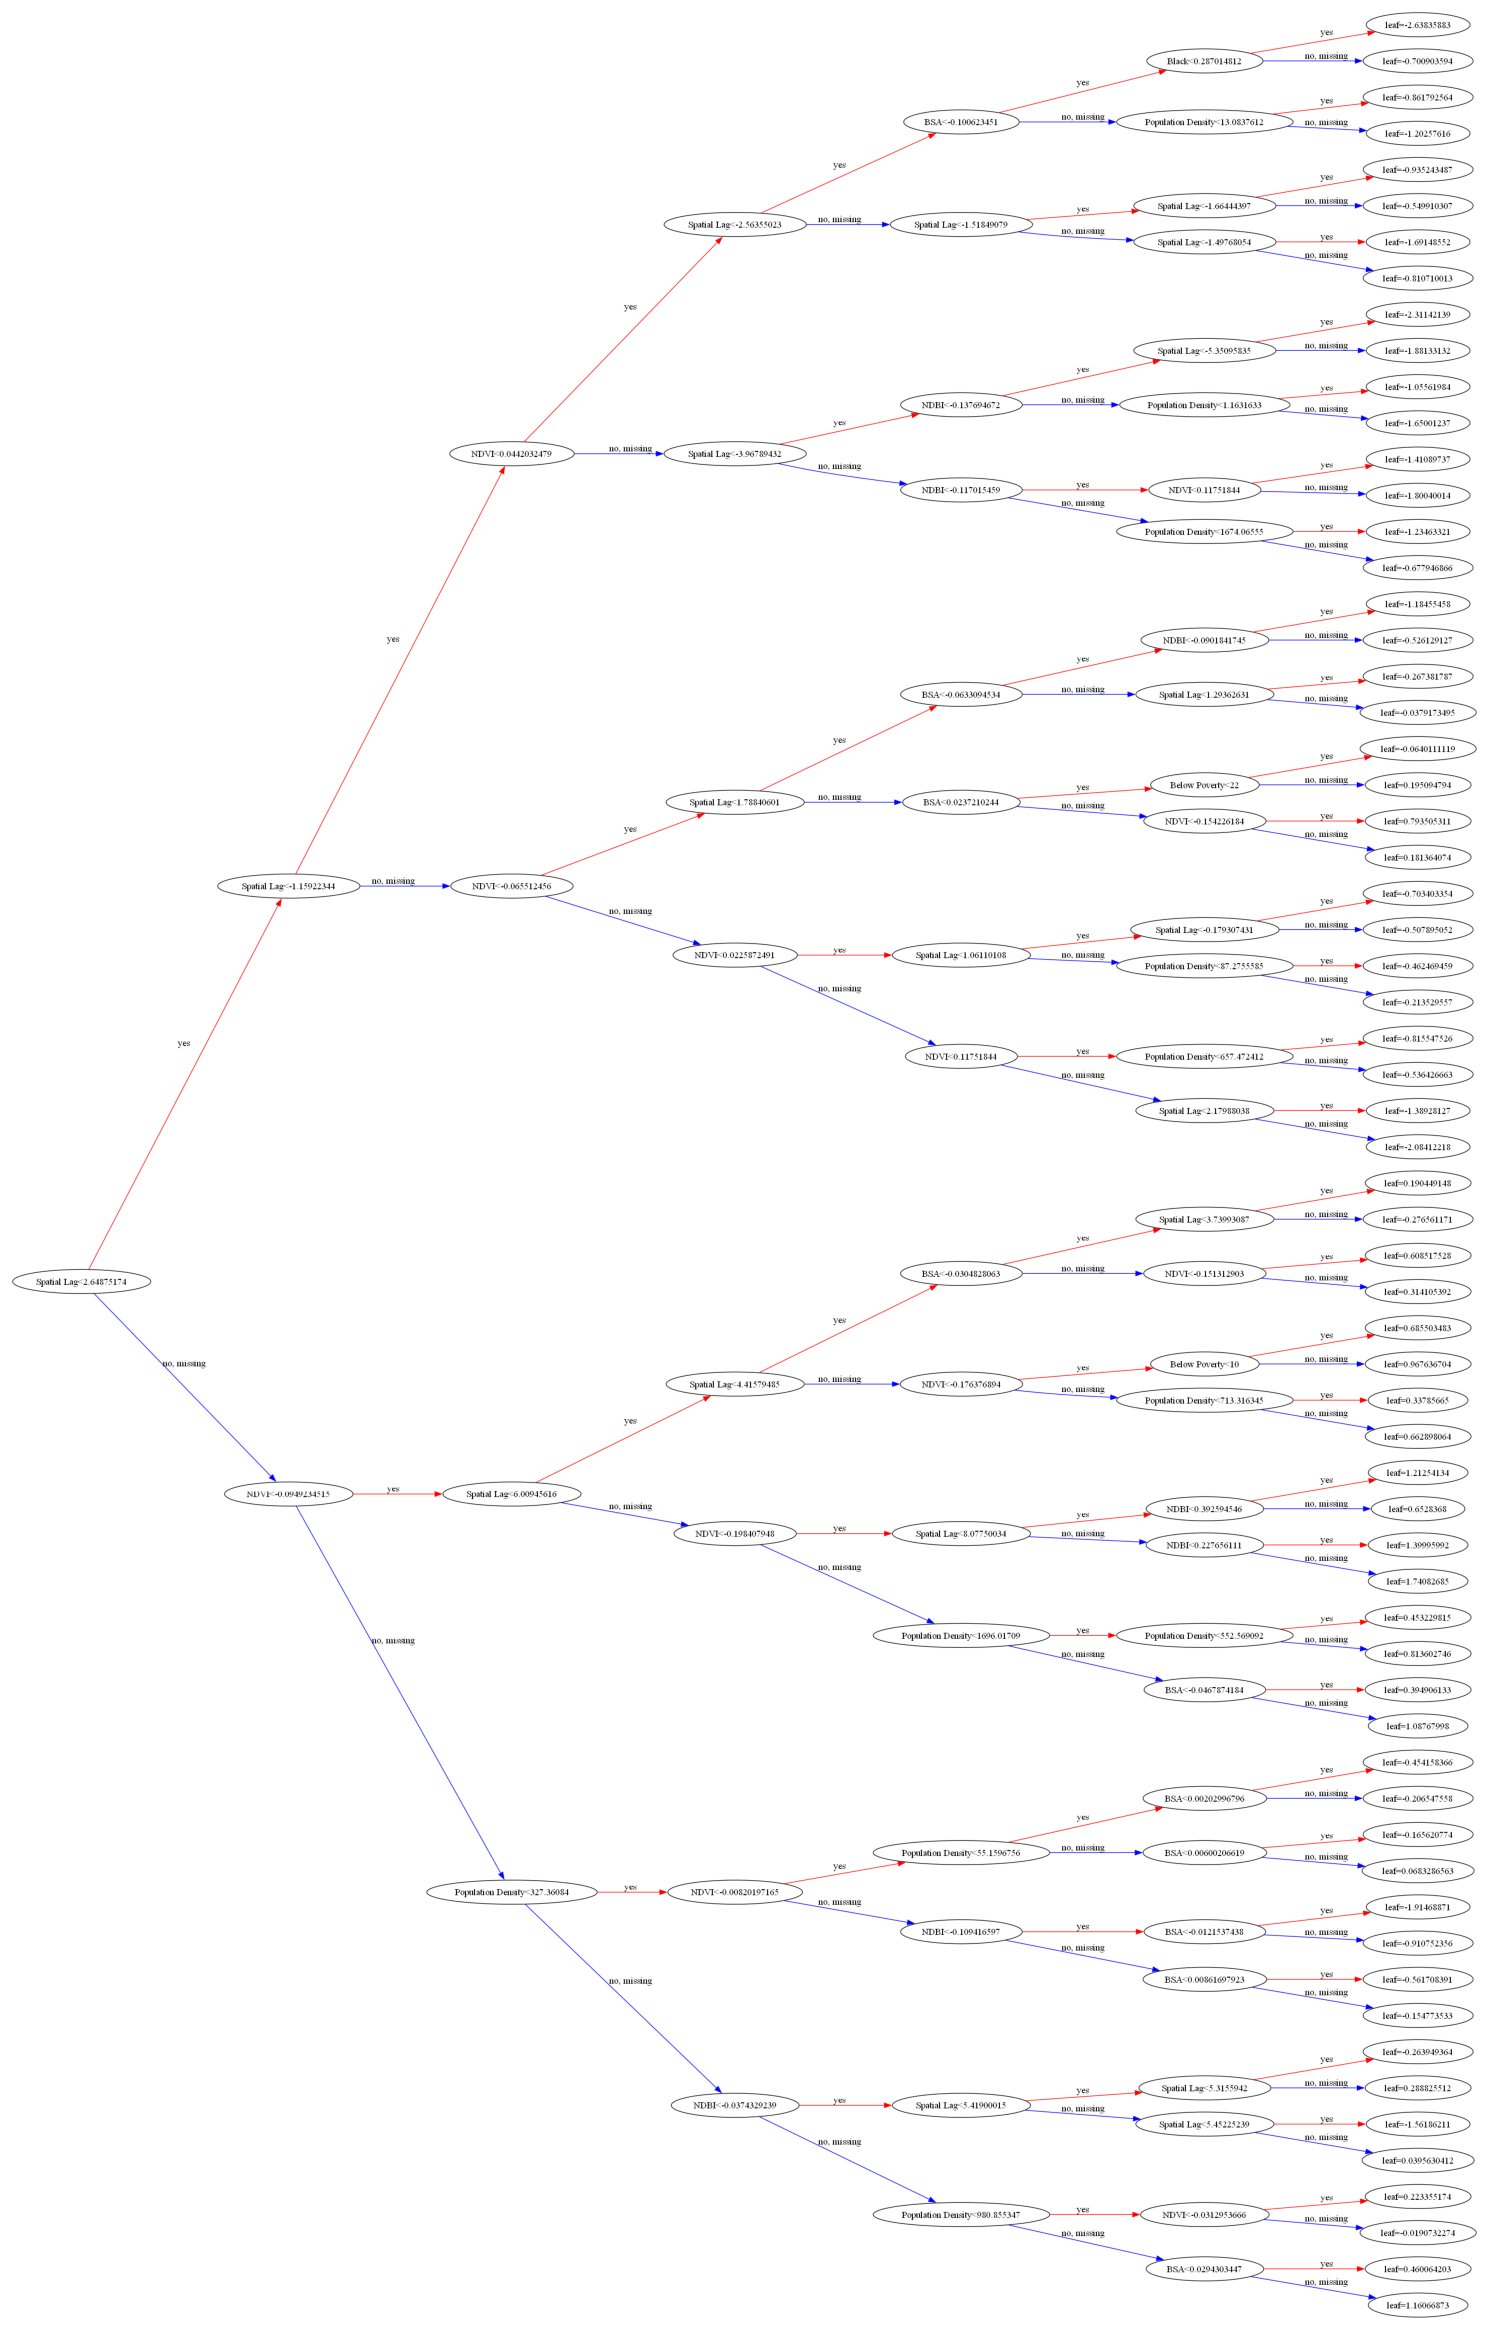

In [13]:
import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/jed/Anaconda3/envs/keras/Library/bin/graphviz/'
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\windows_10_cmake_Release_Graphviz-12.2.1-win64\Graphviz-12.2.1-win64\bin'

fig, ax = plt.subplots(figsize=(30, 30))
xgb.plotting.plot_tree(booster, num_trees=1, rankdir='LR', ax=ax)


### Using the model to predict and evaluate the result

In [14]:
# Make predictions with the test set
## YOUR CODE HERE
y_pred = model.predict(X_test)
print(y_pred) # predicting UHI

[ 0.24470276 -9.530634   -0.64334494 ...  0.5007429   0.49311346
  0.52184737]


In [15]:
# Evaluate the RMSE and R^2 with the test set; For discrete can use confusion matrix for continous use MAE or RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

In [16]:
rmse, r2
print("Root Mean Squared Error : " + str(rmse)+" and R2: "+ str(r2))

Root Mean Squared Error : 1.2993404387149634 and R2: 0.8820535437392667


In [17]:
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(y_pred, y_test)))

Mean Absolute Error : 0.9524468139753275


## Model Interpretation with SHAP
Let's use the SHAP API to interpret our model.

We can do more than just make a bar chart. We can plot the feature importance for every record in our data set. The shap Python package makes this easy. We first call shap.TreeExplainer(model).shap_values(X) to explain every prediction, then call shap.summary_plot(shap_values, X) to plot these explanations:

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

In [19]:
explainer.expected_value

2.9642453

In [20]:
shap_values.shape

(70901, 9)

In [21]:
shap_values

.values =
array([[ 0.04073802,  0.13291252,  0.15272932, ...,  0.36701217,
        -0.8114795 ,  0.8428135 ],
       [ 0.1679011 ,  0.11951873, -0.12101827, ...,  0.69544905,
        -0.27940562,  0.87477255],
       [ 0.02028431, -0.00788973,  0.02823457, ...,  0.4618479 ,
        -0.14309935,  0.6302015 ],
       ...,
       [ 0.00692978, -0.20711043,  0.08725679, ..., -2.00227   ,
        -1.8028265 , -6.303197  ],
       [ 0.06263309, -0.08373029,  0.06968218, ..., -0.11659718,
        -0.56952745, -3.860129  ],
       [-0.16875477,  0.08051024,  0.03088841, ..., -0.07611896,
        -0.921712  , -1.2519441 ]], dtype=float32)

.base_values =
array([2.9642453, 2.9642453, 2.9642453, ..., 2.9642453, 2.9642453,
       2.9642453], dtype=float32)

.data =
array([[ 1.13396889e-01,  1.30456598e-02,  8.81052632e-01, ...,
         7.08852996e-02, -4.83616751e-02,  3.38900601e+00],
       [ 5.82440020e-01,  1.53139357e-02,  3.84286934e-01, ...,
         9.56298187e-02, -8.10700131e-02,  3.313

### SHAP Bar and Beeswarm

How do we design a fair payout scheme? Shapley values are designed to answer this question. Assumes a game with players and a team score. Suppose we could look at all possible combinations of (a subset of) players, replay the game, and observe the resulting team score. We could then assign each player a portion of the total payout based on its average added value acrosse all possible subteams to which it was added.Shapely values are efficent (add to total payoutt), symmetric(2 players get the same if they add the same value in all team combos), dummy-sensitive(player gets value 0 if never improves a subteams performance, additive (sum of parts).

Instead of a game with players we can use the same payout mechanism for a machine learning model with features. The team score in this context is the performance measure of a (sub)model. The total payout is the difference between a base value — prediction of the null model — and an actual prediction. ty.

[SHAP Bar Plots](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html)
* Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

[SHAP Beeswarm Plots](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html)

https://medium.com/bigdatarepublic/feature-importance-whats-in-a-name-79532e59eea3

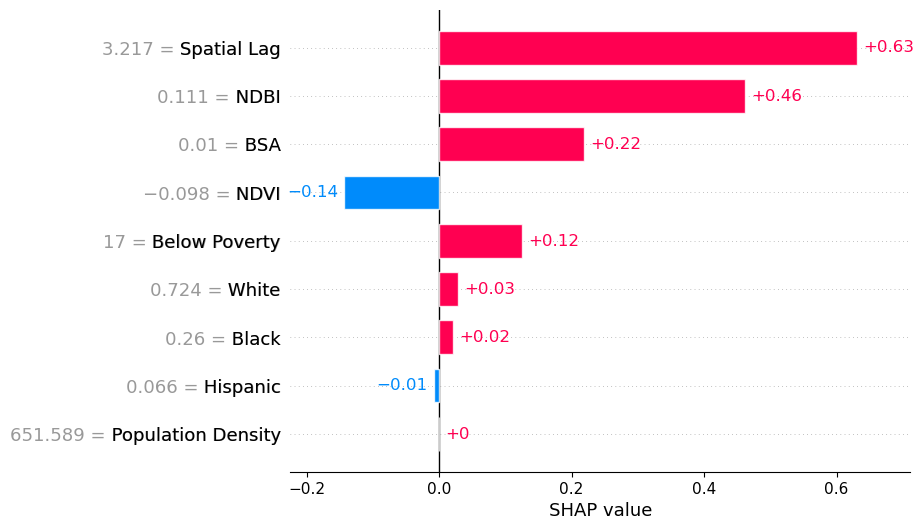

In [22]:
# Passing a single row creates a plot of LOCAL feature importance
shap.plots.bar(shap_values[2])

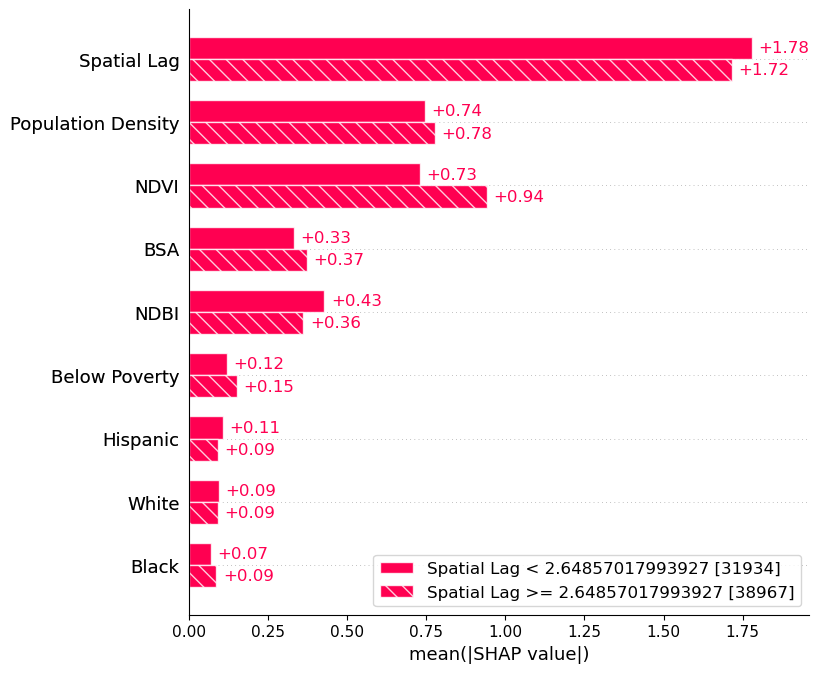

In [23]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

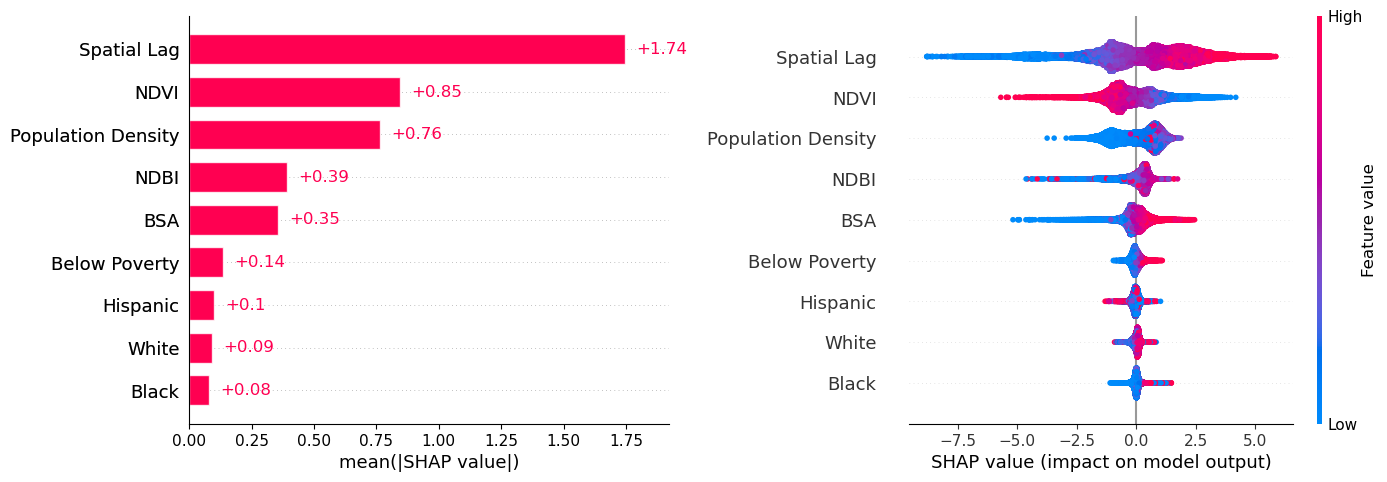

In [24]:
# Create a SHAP bar and beeswarm plot
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
shap.plots.bar(shap_values, max_display=10, show=False)
plt.subplot(1,2,2)
shap.plots.beeswarm(shap_values, max_display=10, show=False)

# Optional for adjusting the margins:
plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=2.5, 
    top=0.9,
    wspace = 0.5)

By plotting the impact of a feature on every sample we can also see important outlier effects. For example, spatial lag is the most important feature globally if we ignore that for now, we can see that NDVI and BSA are the most important for some subset of customers

In the Beeswarm, the coloring by feature value shows us patterns, for example NDVI and BSA both have a distinct RED/Blue division (population density has a lot of blue all across) -- this red/blue division means lower NDVI's increase UHI, while BSA is reversed, higher BSA, increase UHI.

### SHAP Scatter Plots
[SHAP Scatter Plots](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html)

Create a SHAP scatter plot by race. Show the interaction effect of poverty.

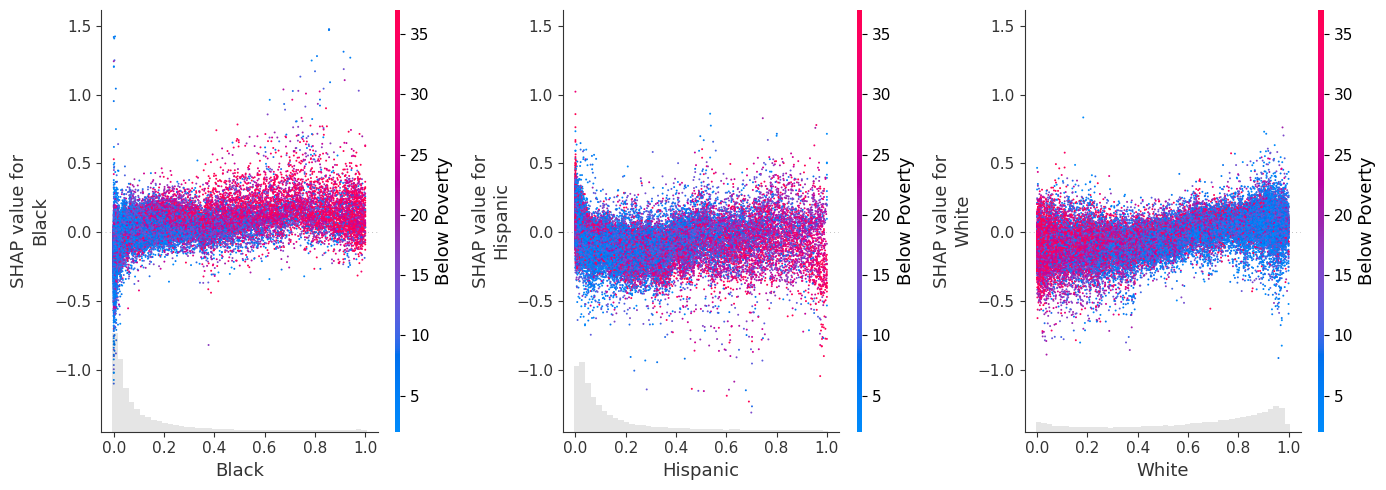

In [25]:
race = ['Black', 'Hispanic', 'White']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=True)
for i in range(3):
    shap.plots.scatter(shap_values[:, race[i]], color=shap_values[:, 'Below Poverty'], show=False, ax=axes[i], dot_size=2)

plt.tight_layout()

Create a SHAP scatter plot by race. Show the interaction effect of NDBI, NDVI, BSA, and population density.

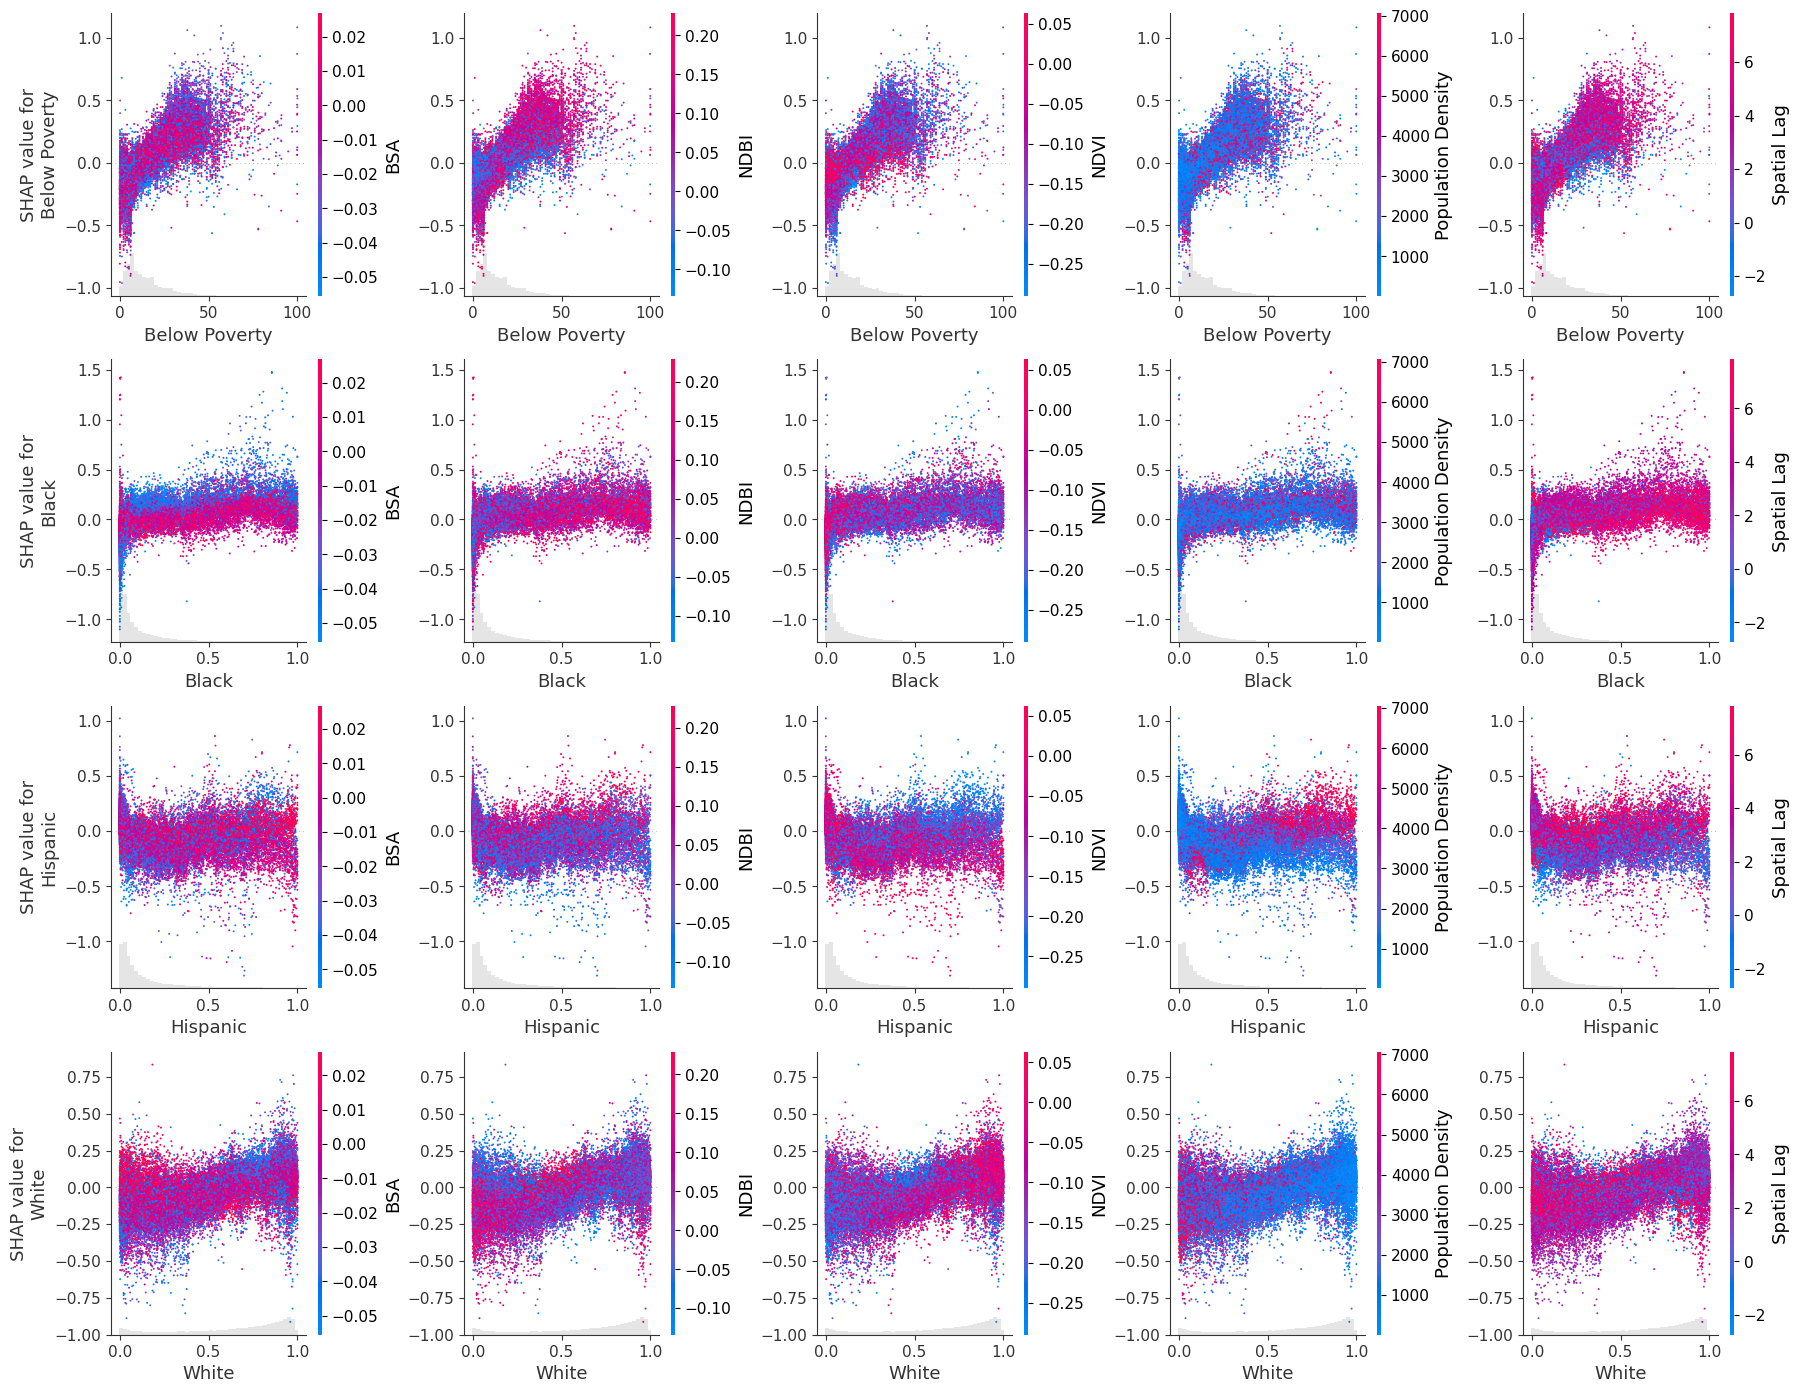

In [46]:
nrows, ncols = 4, 5
demo = ['Below Poverty', 'Black', 'Hispanic', 'White'] 
env = ['BSA', 'NDBI', 'NDVI', 'Population Density', 'Spatial Lag'] #spatial lag is not included?


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,14))
for i in range(nrows):
    for j in range(ncols):
        shap.plots.scatter(shap_values[:, demo[i]], color=shap_values[:, env[j]], show=False, ax=axes[i,j], dot_size=2)
        if j > 0:
            axes[i,j].set(ylabel=None) # turn off y axis since it's redundant
        
plt.tight_layout()

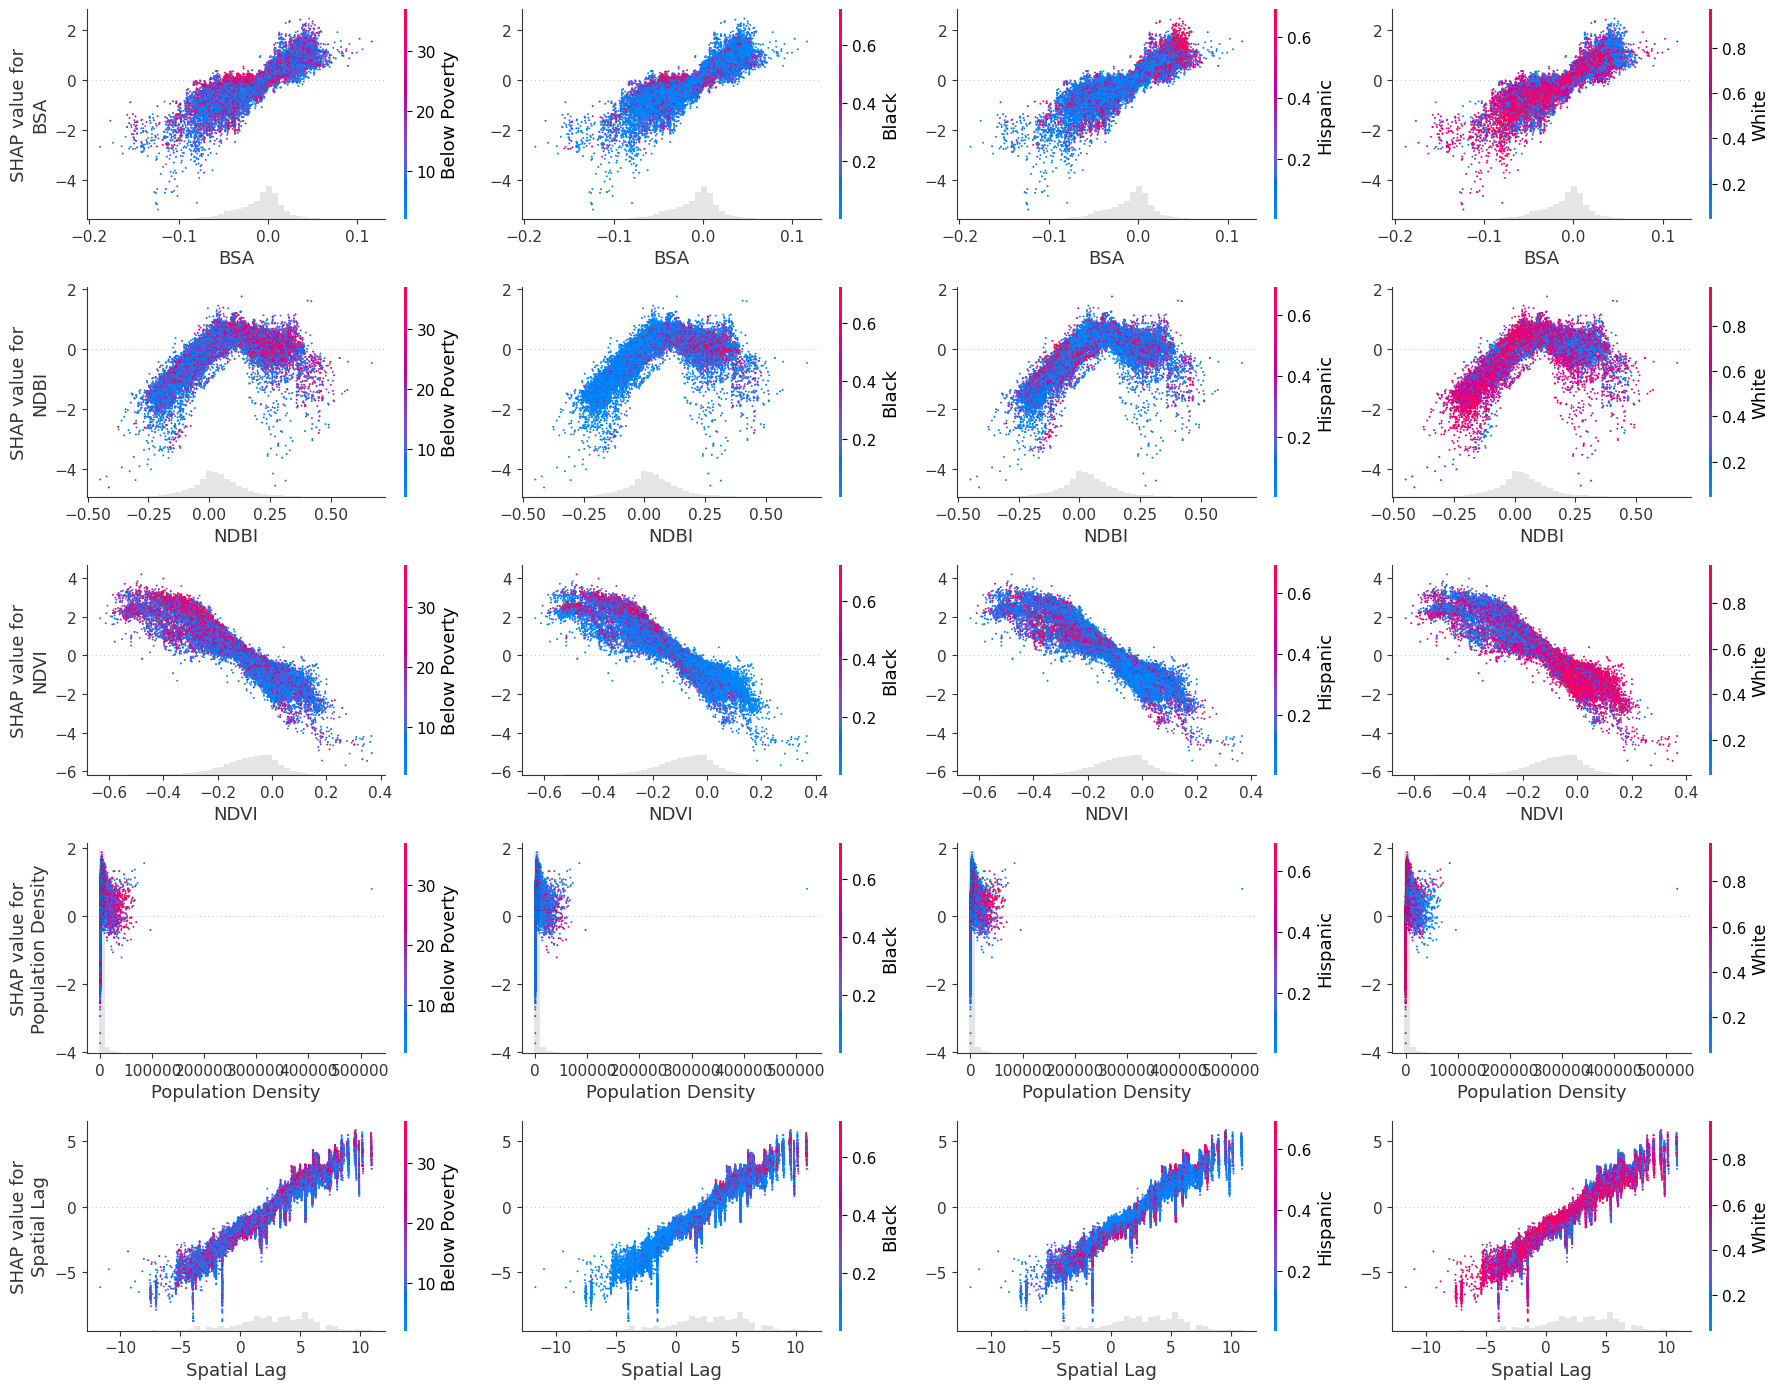

In [47]:
nrows, ncols = 5, 4
demo = ['Below Poverty', 'Black', 'Hispanic', 'White'] 
env = ['BSA', 'NDBI', 'NDVI', 'Population Density', 'Spatial Lag']


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,14))
for i in range(nrows):
    for j in range(ncols):
        shap.plots.scatter(shap_values[:, env[i]], color=shap_values[:, demo[j]], show=False, ax=axes[i,j], dot_size=2)
        if j > 0:
            axes[i,j].set(ylabel=None) # turn off y axis since it's redundant
        
plt.tight_layout()

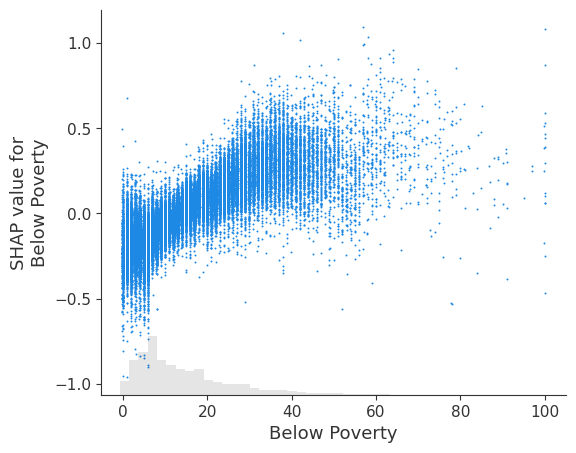

In [27]:
# 0 = Below Poverty, 1 = Black
# let’s instead dig a bit deeper into some of these features. 
# We can do that for the age feature by plotting the "Black" SHAP values (changes in log odds) vs. the Black feature values:

shap.plots.scatter(shap_values[:, demo[0]], show=False,  dot_size=2)
#The y-axis is how much the  feature changes the log odds of UHI.
# The x-axis is the feature of each row. Each dot represents a single row from the data set.

#Note that unlike traditional partial dependence plots (which show the average model output when changing a feature’s value) 
#these SHAP dependence plots show interaction effects. 
# how much "feature" impacts the prediction differs as shown by the vertical dispersion of dots

#Dispersion means other features are impacting the importance of that feature.
#To see what feature might be part of this effect we color the dots by another feature

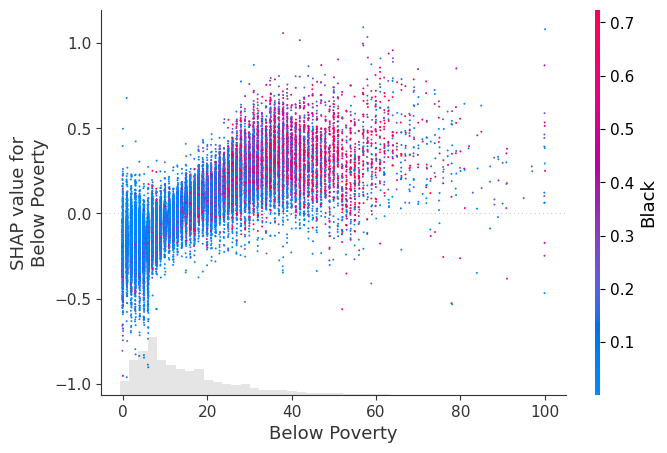

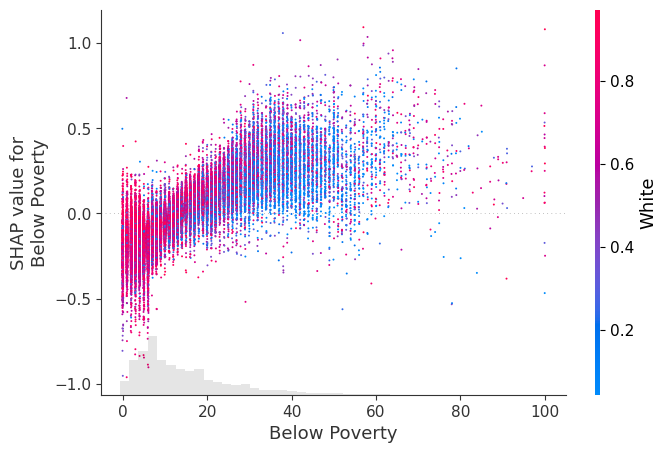

In [28]:
#demo 
shap.plots.scatter(shap_values[:, demo[0]],  color=shap_values[:, demo[1]], show=False,  dot_size=2)
shap.plots.scatter(shap_values[:, demo[0]],  color=shap_values[:, demo[3]], show=False,  dot_size=2)

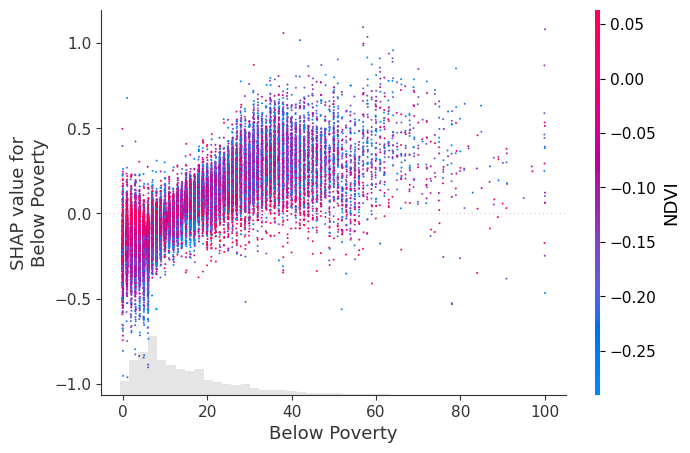

In [37]:
shap.plots.scatter(shap_values[:, 'Below Poverty'],  color=shap_values[:, 'NDVI'], show=False,  dot_size=2)

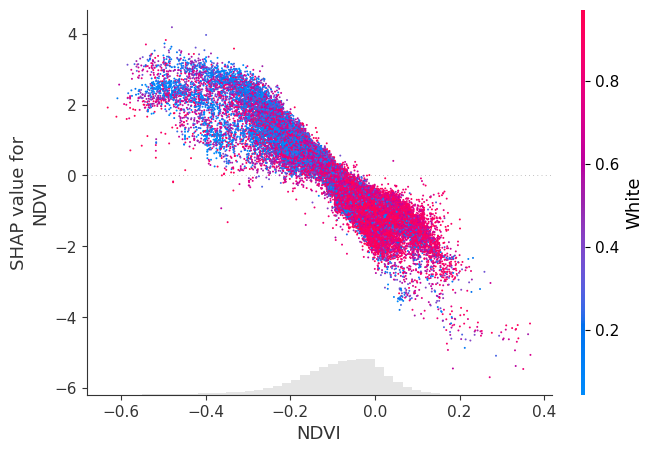

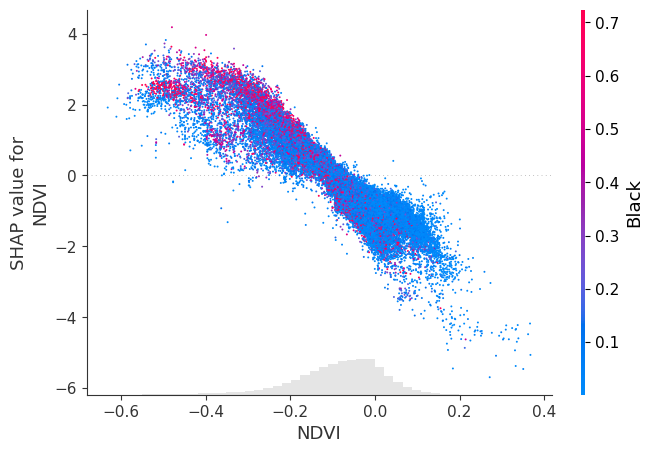

In [34]:
shap.plots.scatter(shap_values[:, 'NDVI'],  color=shap_values[:, 'White'], show=False,  dot_size=2)
shap.plots.scatter(shap_values[:, 'NDVI'],  color=shap_values[:, 'Black'], show=False,  dot_size=2)

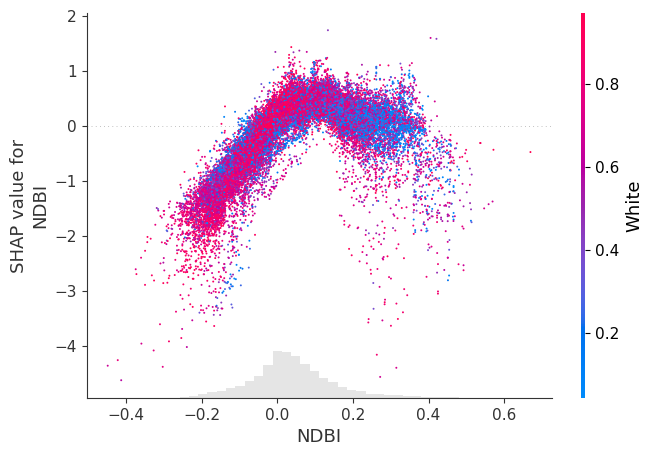

In [48]:
shap.plots.scatter(shap_values[:, 'NDBI'],  color=shap_values[:, 'White'], show=False,  dot_size=2)

# SHAP Partial Dependency Plots

To understand a feature’s importance in a model, it is necessary to understand both how changing that feature impacts the model’s output, and also the distribution of that feature’s values. To visualize this for a linear model we can build a classical partial dependence plot and show the distribution of feature values as a histogram on the x-axis:

Grey lines show expected values
 blue partial dependence plot line (which is the average value of the model output when we fix the feature to a given value)

https://scikit-learn.org/stable/modules/partial_dependence.html

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.  These interpretations are marginal, considering a feature at a time.

 A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex.

 In practice, the set of features S usually only contains one feature or a maximum of two, because one feature produces 2D plots and two features produce 3D plots. Everything beyond that is quite tricky. Even 3D on a 2D paper or monitor is already challenging

The partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that feature value.

If the feature for which you computed the PDP is not correlated with the other features, then the PDPs perfectly represent how the feature influences the prediction on average. In the uncorrelated case, the interpretation is clear: The partial dependence plot shows how the average prediction in your dataset changes when the j-th feature is changed.

The assumption of independence is the biggest issue with PD plots. It is assumed that the feature(s) for which the partial dependence is computed are not correlated with other features.

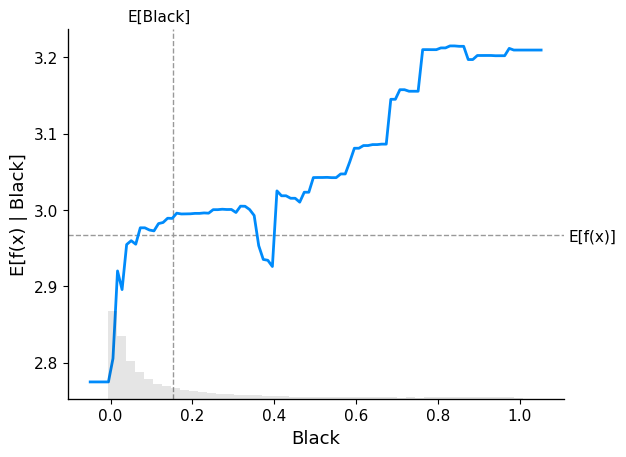

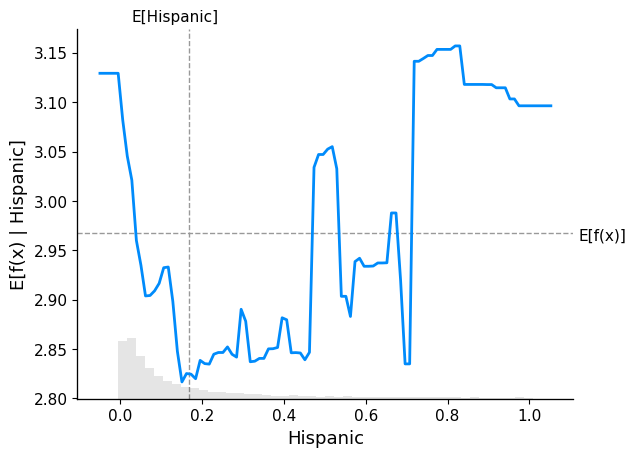

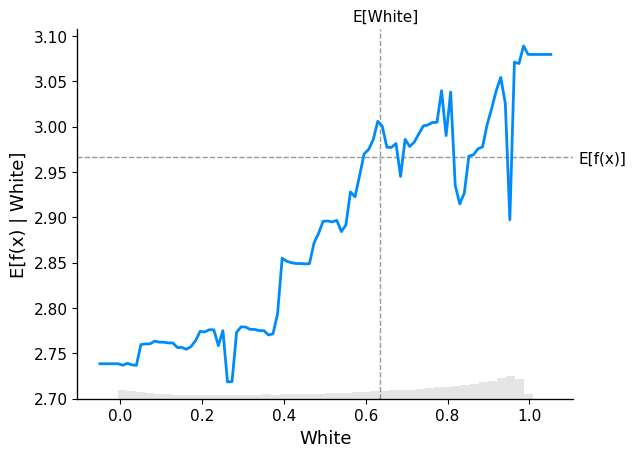

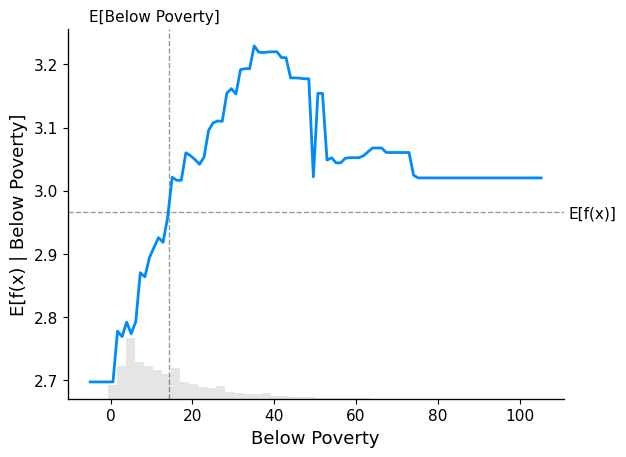

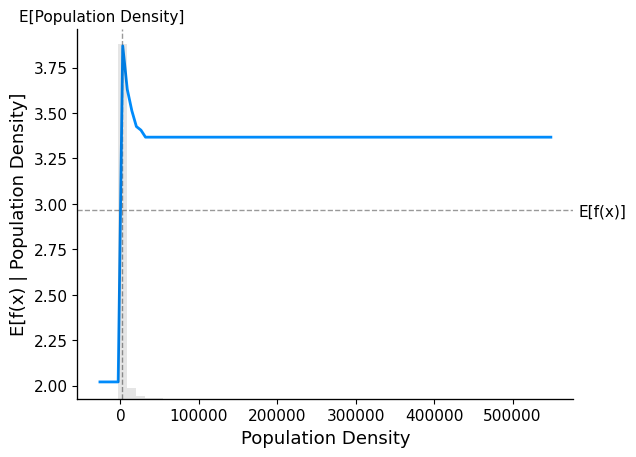

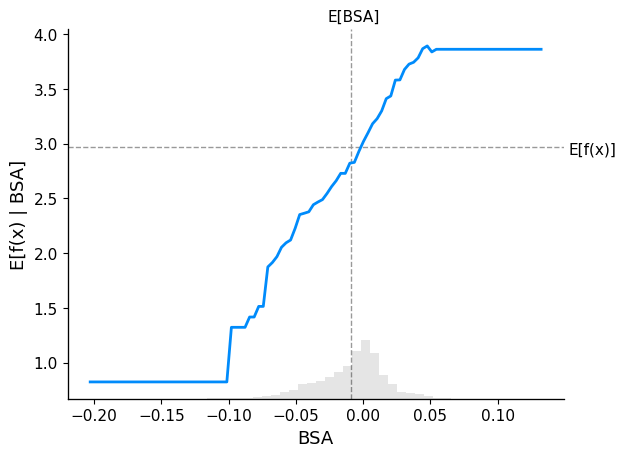

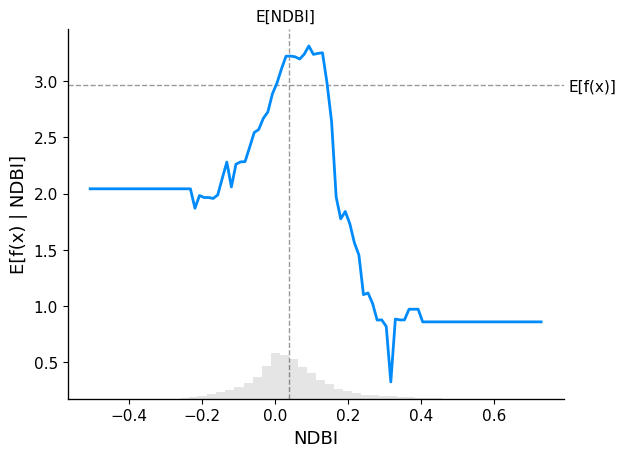

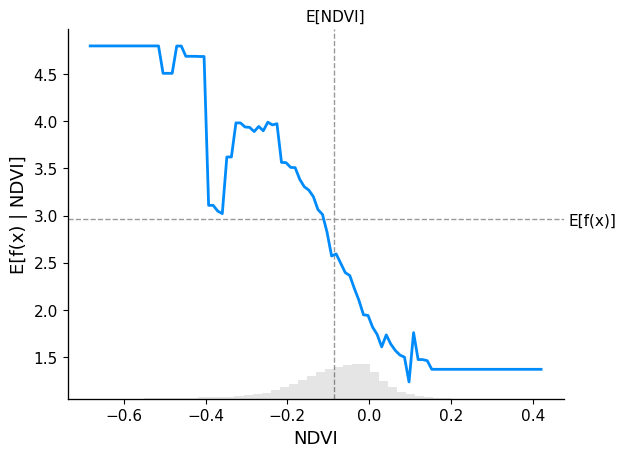

In [29]:
for i in range(8):
    shap.plots.partial_dependence(features[i], 
                                  model.predict, 
                                  data[features], 
                                  model_expected_value=True, 
                                  feature_expected_value=True, 
                                  ice=False, 
                                  show=False)

PDPs with two input features of interest show the interactions among the two features.

Similar to a PDP, an individual conditional expectation (ICE) plot shows the dependence between the target function and an input feature of interest. However, unlike a PDP, which shows the average effect of the input feature, an ICE plot visualizes the dependence of the prediction on a feature for each sample separately with one line per sample.

Computing partial dependence plots...


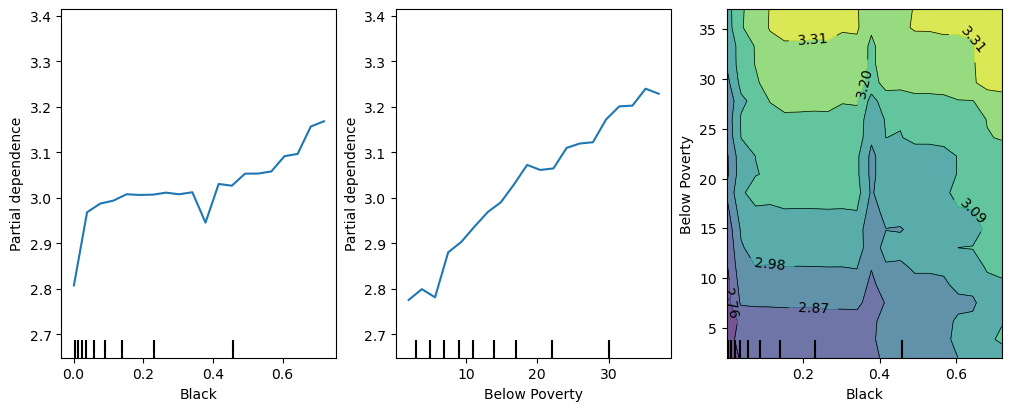

In [30]:
from sklearn.inspection import PartialDependenceDisplay

print("Computing partial dependence plots...")

features_info = {
    "features": ["Black", "Below Poverty", ("Black", "Below Poverty")],
    "kind": "average",
}

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    **features_info,
    ax=ax,
    **common_params,
)


In [31]:
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values.values, X_train)

In [35]:
# use environmental factors as a heat map by race?

Computing partial dependence plots...


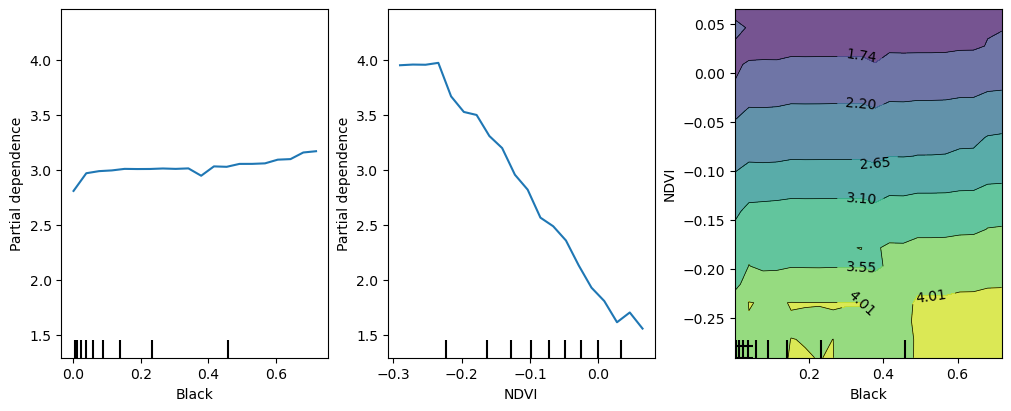

In [36]:
from sklearn.inspection import PartialDependenceDisplay

print("Computing partial dependence plots...")

features_info = {
    "features": ["Black", "NDVI", ("Black", "NDVI")],
    "kind": "average",
}

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)

display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    **features_info,
    ax=ax,
    **common_params,
)


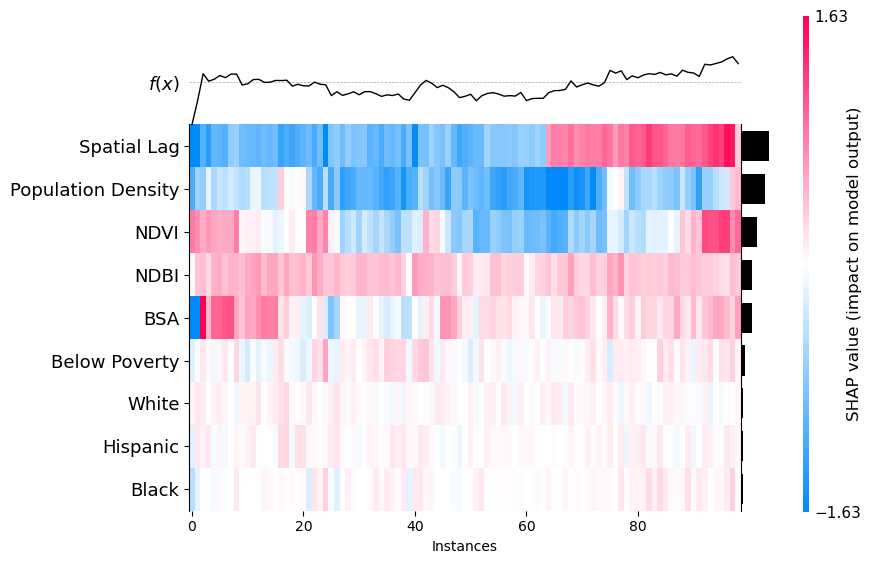

<Axes: xlabel='Instances'>

In [43]:
#arbitrarily choose 100 samples
shap.plots.heatmap(shap_values[1:100])
# The horizontal bars on the right side rank the variables from the most important to the least important. 
#The model variable importance represents global interpretability. Spatial lag is mot important attribute to UHI followed by population density etc.
# The colors show the magnitude of the SHAP value
# the f(x) on top is the model prediction curve

# the center of the 2D heatmap is the base_value (using .base_value), which is the mean prediction for all instances. Its saved in the SHAP Values
# If you choose a different 100 samples, the heatmap will look different